In [19]:
import pandas as pd
import numpy as np

In [20]:
df = pd.read_excel("../Dataset.xlsx")

In [21]:
df['Home'] = df['Match Up'].apply(lambda x: 0 if '@' in x else (1 if 'vs.' in x else None))
df['Game Date'] = pd.to_datetime(df['Game Date'], format='%m/%d/%Y')

In [22]:
def get_opponent_row(df, current_row):
    # Extract game details
    match_up = current_row['Match Up']
    game_date = current_row['Game Date']
    current_team = current_row['Team']

    # Identify the opposing team
    team_A, team_B = match_up[:3], match_up[-3:]
    opponent_team = team_B if current_team == team_A else team_A

    # Find the row corresponding to the opponent
    opponent_row = df[
        (df['Game Date'] == game_date) & (df['Team'] == opponent_team)
    ]

    return opponent_row

def specific_win_rate(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        other_games = df[df['Match Up'].str.contains(team_A) & df['Match Up'].str.contains(team_B) & (df["Team"] == row["Team"])]
        date = row["Game Date"]
        prior_games = other_games[other_games["Game Date"] < date]
        if(len(prior_games) == 0):
            prior_rate = 50
        else: 
            prior_wins = (prior_games["W/L"] == "W").sum()
            prior_rate = (prior_wins/len(prior_games)) * 100
        df.loc[i,"Specific Win Percent"] = prior_rate

specific_win_rate(df)

def general_win_percent(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        if(len(prior_games) == 0):
            prior_rate = 50
        else:
            prior_wins = (prior_games["W/L"] == "W").sum()
            prior_rate = (prior_wins/len(prior_games)) * 100
        df.loc[i,"General Win Percent"] = prior_rate

general_win_percent(df)

def PTS_Var(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team = row["Team"]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        if(len(prior_games) == 0):
            PTS_Var = 0
        else:
            PTS_Var = prior_games["PTS"].var()
        df.loc[i,"PTS Var"] = PTS_Var

PTS_Var(df)

def PTS_Var_Diff(df):
    df["PTS Var Diff"] = np.nan  

    for i in range(len(df)): 
            row = df.iloc[i,:]
            my_pts_var = row["PTS Var"]
            opponent = get_opponent_row(df, row)
            opp_pts_var = opponent["PTS Var"]
            diff = my_pts_var - opp_pts_var
            df.loc[i,"PTS Var Diff"] = diff.iloc[0]


PTS_Var_Diff(df)

In [23]:
def last_5_win_percent(df):
    for i in range(len(df)):
        row = df.iloc[i, :]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        
        if len(prior_games) == 0:
            # Default to 50% if no prior games exist
            prior_rate = 50
        elif len(prior_games) < 5:
            # Calculate win percentage for all prior games
            prior_wins = (prior_games["W/L"] == "W").sum()
            prior_rate = (prior_wins / len(prior_games)) * 100
        else:
            # Sort and calculate win percentage for the last 5 prior games
            sorted_df = prior_games.sort_values(by='Game Date')
            last5 = sorted_df.tail(5)
            prior_wins = (last5["W/L"] == "W").sum()
            prior_rate = (prior_wins / len(last5)) * 100
        
        # Assign the calculated value
        df.at[i, "Last 5 Win Percent"] = prior_rate

last_5_win_percent(df)

def LFWP(df):
     for i in range(len(df)):
        row = df.iloc[i,:]
        my_lfwp = row["Last 5 Win Percent"]
        opponent = get_opponent_row(df, row)
        opp_lfwp = opponent["Last 5 Win Percent"]
        diff = my_lfwp - opp_lfwp
        df.loc[i,"LFWP Diff"] = diff.iloc[0]

LFWP(df)


In [24]:
def calculate_win_rate_difference(df):
    df["Win Rate Difference"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Find the opponent's General Win Percent
        opponent_row = df[
            (df["Team"] == opponent_team) &
            (df["Game Date"] == row["Game Date"])
        ]

        if not opponent_row.empty:
            opponent_rate = opponent_row["General Win Percent"].values[0]
        else:
            opponent_rate = 50  # Default if no opponent info

        # Calculate the difference
        current_team_rate = row["General Win Percent"]
        df.loc[i, "Win Rate Difference"] = current_team_rate - opponent_rate

calculate_win_rate_difference(df)


In [25]:
def calculate_avg_pts(df):
    for i in range(len(df)):
        row = df.iloc[i, :]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]

        # Get prior games for the current team
        prior_games = team_games[team_games["Game Date"] < date]
        if len(prior_games) == 0:
            avg_pts = 0  # Default if no prior games
        else:
            avg_pts = prior_games["PTS"].mean()  # Calculate average points

        # Add the calculated average to a new column
        df.loc[i, "Avg PTS"] = avg_pts

calculate_avg_pts(df)

In [26]:
def calculate_pts_diff(df):
    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Get the opponent's Avg PTS
        opponent_row = df[
            (df["Team"] == opponent_team) &
            (df["Game Date"] == row["Game Date"])
        ]

        if not opponent_row.empty:
            opponent_avg_pts = opponent_row["Avg PTS"].values[0]
        else:
            opponent_avg_pts = 0  # Default if no data for opponent

        # Calculate the PTS difference
        pts_diff = row["Avg PTS"] - opponent_avg_pts
        df.loc[i, "Avg PTS Difference"] = pts_diff

# Apply the function
calculate_pts_diff(df)


In [27]:
def calculate_avg_plus_minus(df):
    df["Avg +/-"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        current_team = row["Team"]
        game_date = row["Game Date"]

        # Filter for prior games of the same team
        prior_games = df[(df["Team"] == current_team) & (df["Game Date"] < game_date)]

        if len(prior_games) == 0:
            avg_plus_minus = 0  # Default if no prior games
        else:
            avg_plus_minus = prior_games["+/-"].mean()

        # Assign the calculated average
        df.loc[i, "Avg +/-"] = avg_plus_minus

calculate_avg_plus_minus(df)

In [28]:
def calculate_plus_minus_difference(df):
    df["+/- Difference"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Find the Avg +/- of the opponent
        opponent_avg_plus_minus = df.loc[
            (df["Team"] == opponent_team) & (df["Game Date"] == row["Game Date"]),
            "Avg +/-"
        ]
        
        if not opponent_avg_plus_minus.empty:
            opponent_avg_plus_minus = opponent_avg_plus_minus.values[0]
        else:
            opponent_avg_plus_minus = 0  # Default if no opponent info

        # Calculate the difference
        df.loc[i, "+/- Difference"] = row["Avg +/-"] - opponent_avg_plus_minus

calculate_plus_minus_difference(df)


In [29]:
def calculate_avg_points_conceded(df):
    df["Avg Points Conceded"] = 0  # Initialize the new column with 0

    for i in range(len(df)):
        row = df.iloc[i]
        current_team = row["Team"]
        game_date = row["Game Date"]

        # Find prior games where the current team played
        prior_games = df[(df["Team"] != current_team) & (df["Match Up"].str.contains(current_team)) & (df["Game Date"] < game_date)]

        if len(prior_games) == 0:
            avg_points_conceded = 0  # Default if no prior games
        else:
            # Use the PTS column from the opponent in those games
            avg_points_conceded = prior_games["PTS"].mean()

        # Assign the result
        df.loc[i, "Avg Points Conceded"] = avg_points_conceded

calculate_avg_points_conceded(df)


In [30]:
'''import pandas as pd
from datetime import datetime

def calculate_weighted_win_rate(df):
    df["Weighted Win Rate"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        current_team = row["Team"]
        game_date = row["Game Date"]  # Directly use the timestamp

        # Filter prior games for the current team
        prior_games = df[(df["Team"] == current_team) & (df["Game Date"] < row["Game Date"])]

        if len(prior_games) == 0:
            weighted_win_rate = 50  # Default if no prior games
        else:
            # Calculate weights based on recency (e.g., days since game)
            prior_games["Game Date"] = pd.to_datetime(prior_games["Game Date"])
            prior_games["Days Since Game"] = (game_date - prior_games["Game Date"]).dt.days
            prior_games["Weight"] = 1 / (prior_games["Days Since Game"] + 1)  # Add 1 to avoid division by zero

            # Calculate weighted wins
            prior_games["Win"] = prior_games["W/L"].apply(lambda x: 1 if x == "W" else 0)
            weighted_wins = (prior_games["Win"] * prior_games["Weight"]).sum()
            total_weights = prior_games["Weight"].sum()

            # Calculate weighted win rate
            weighted_win_rate = (weighted_wins / total_weights) * 100

        # Assign the result
        df.loc[i, "Weighted Win Rate"] = weighted_win_rate

calculate_weighted_win_rate(df)
'''

'import pandas as pd\nfrom datetime import datetime\n\ndef calculate_weighted_win_rate(df):\n    df["Weighted Win Rate"] = None  # Initialize the new column\n\n    for i in range(len(df)):\n        row = df.iloc[i]\n        current_team = row["Team"]\n        game_date = row["Game Date"]  # Directly use the timestamp\n\n        # Filter prior games for the current team\n        prior_games = df[(df["Team"] == current_team) & (df["Game Date"] < row["Game Date"])]\n\n        if len(prior_games) == 0:\n            weighted_win_rate = 50  # Default if no prior games\n        else:\n            # Calculate weights based on recency (e.g., days since game)\n            prior_games["Game Date"] = pd.to_datetime(prior_games["Game Date"])\n            prior_games["Days Since Game"] = (game_date - prior_games["Game Date"]).dt.days\n            prior_games["Weight"] = 1 / (prior_games["Days Since Game"] + 1)  # Add 1 to avoid division by zero\n\n            # Calculate weighted wins\n            p

In [31]:
df.fillna(0, inplace=True)
df.replace('-', 0, inplace=True)
df['W/L'] = df['W/L'].apply(lambda x: 1 if x == 'W' else 0)
df
y = df["W/L"]
X = df.loc[:, ["Win Rate Difference", "Specific Win Percent", "+/- Difference", "PTS Var", "Home", "Avg PTS", "Last 5 Win Percent", "LFWP Diff", "Avg +/-", "Avg Points Conceded", "General Win Percent"]]

In [32]:
#X.describe()
column_names_list = df.columns.tolist()
print(column_names_list)

['Team', 'Match Up', 'Game Date', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'Home', 'Specific Win Percent', 'General Win Percent', 'PTS Var', 'PTS Var Diff', 'Last 5 Win Percent', 'LFWP Diff', 'Win Rate Difference', 'Avg PTS', 'Avg PTS Difference', 'Avg +/-', '+/- Difference', 'Avg Points Conceded']


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

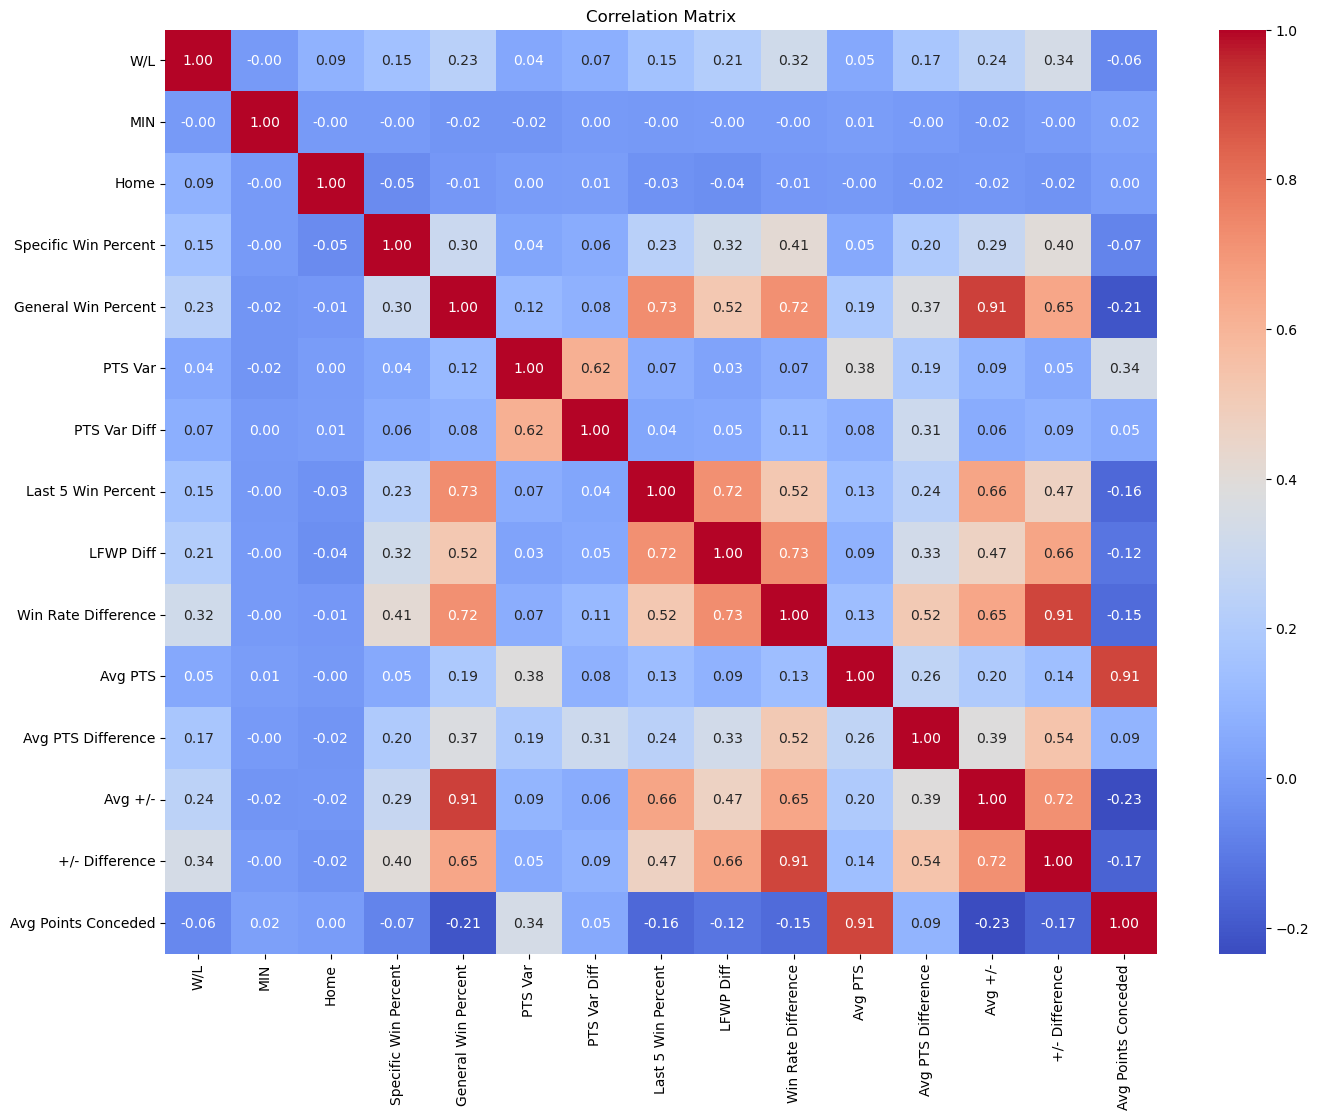

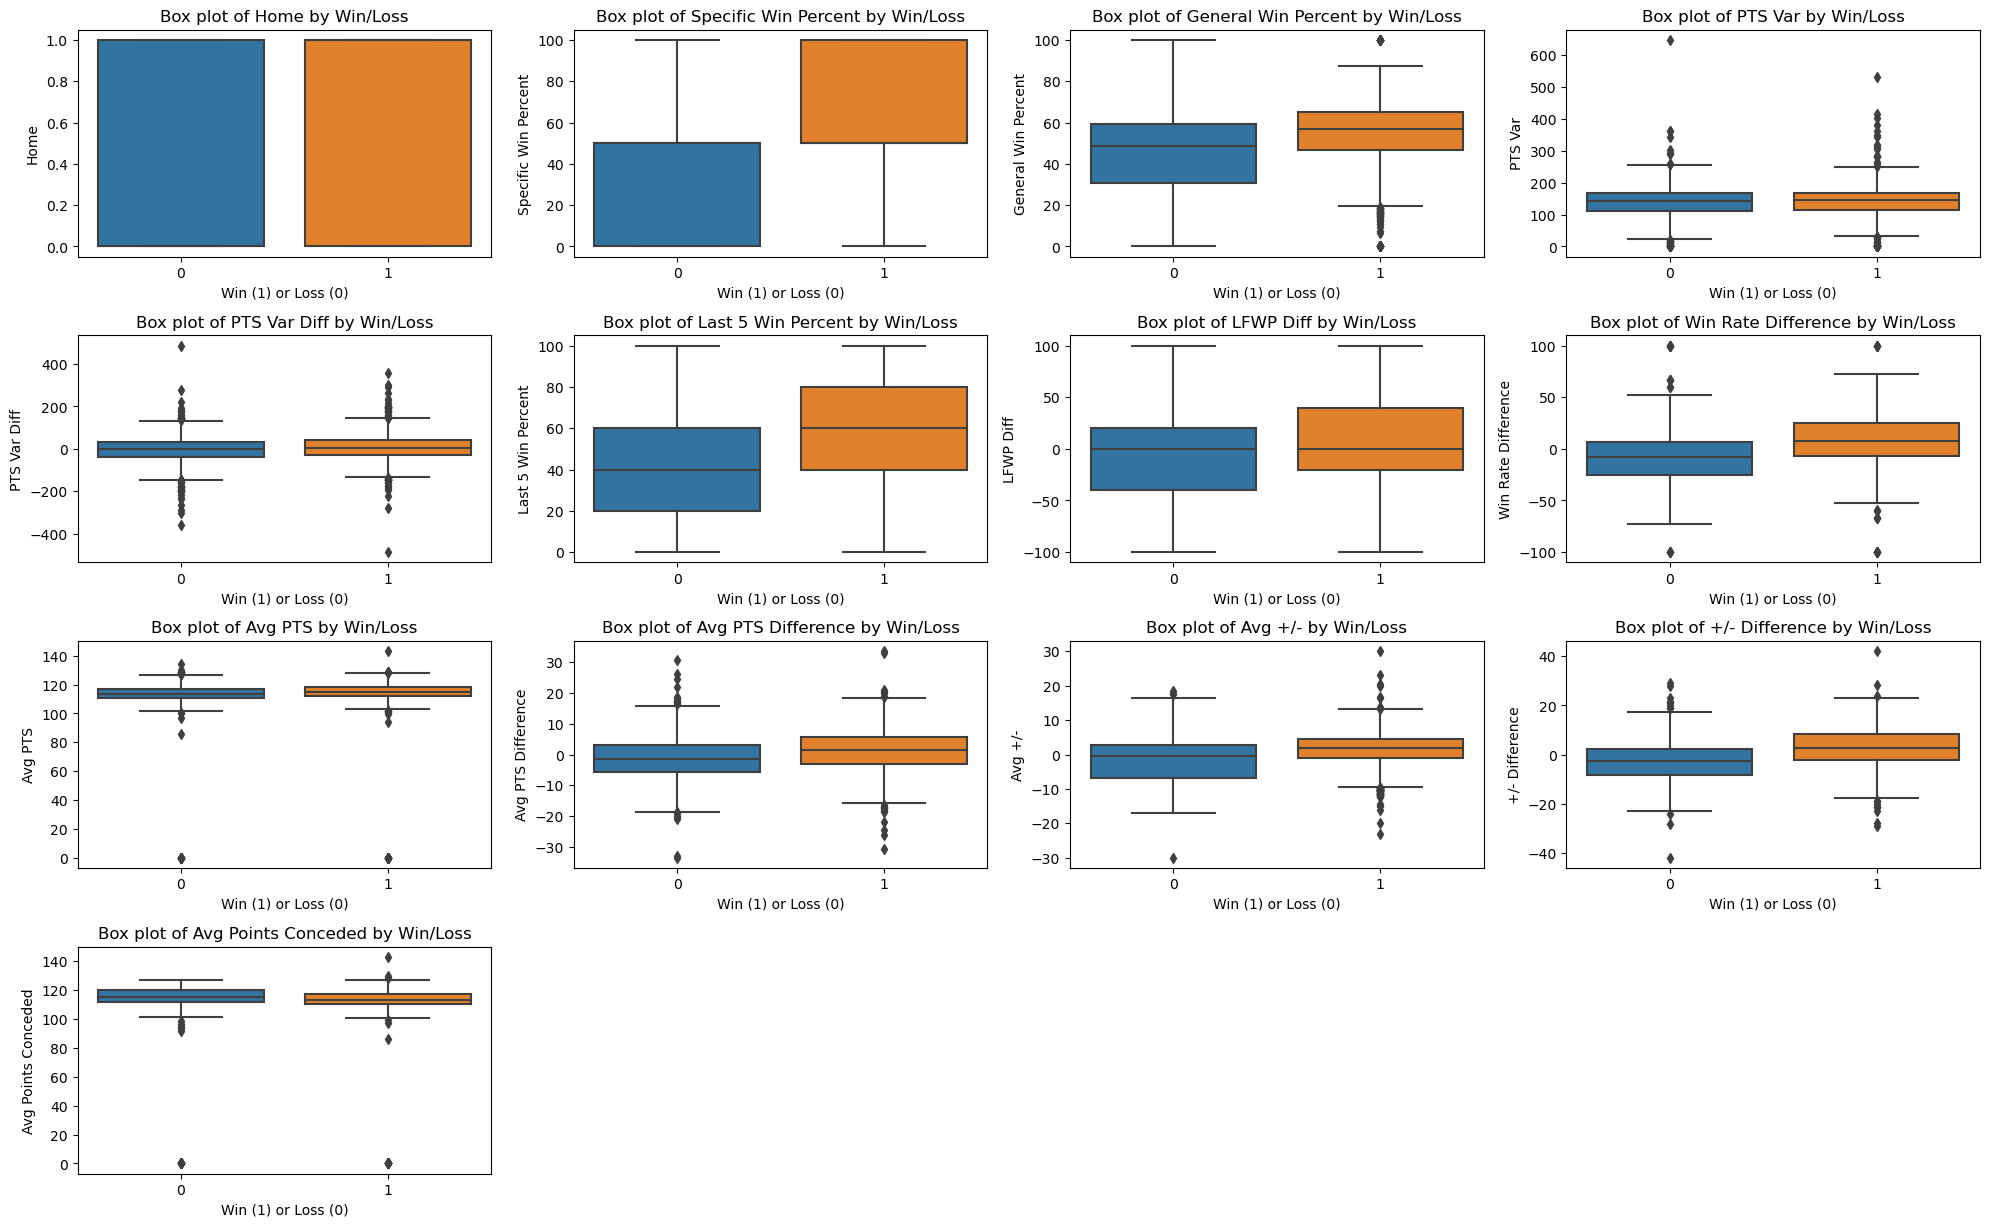

/Users/bowenzheng/opt/anaconda3/envs/PIC16B/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


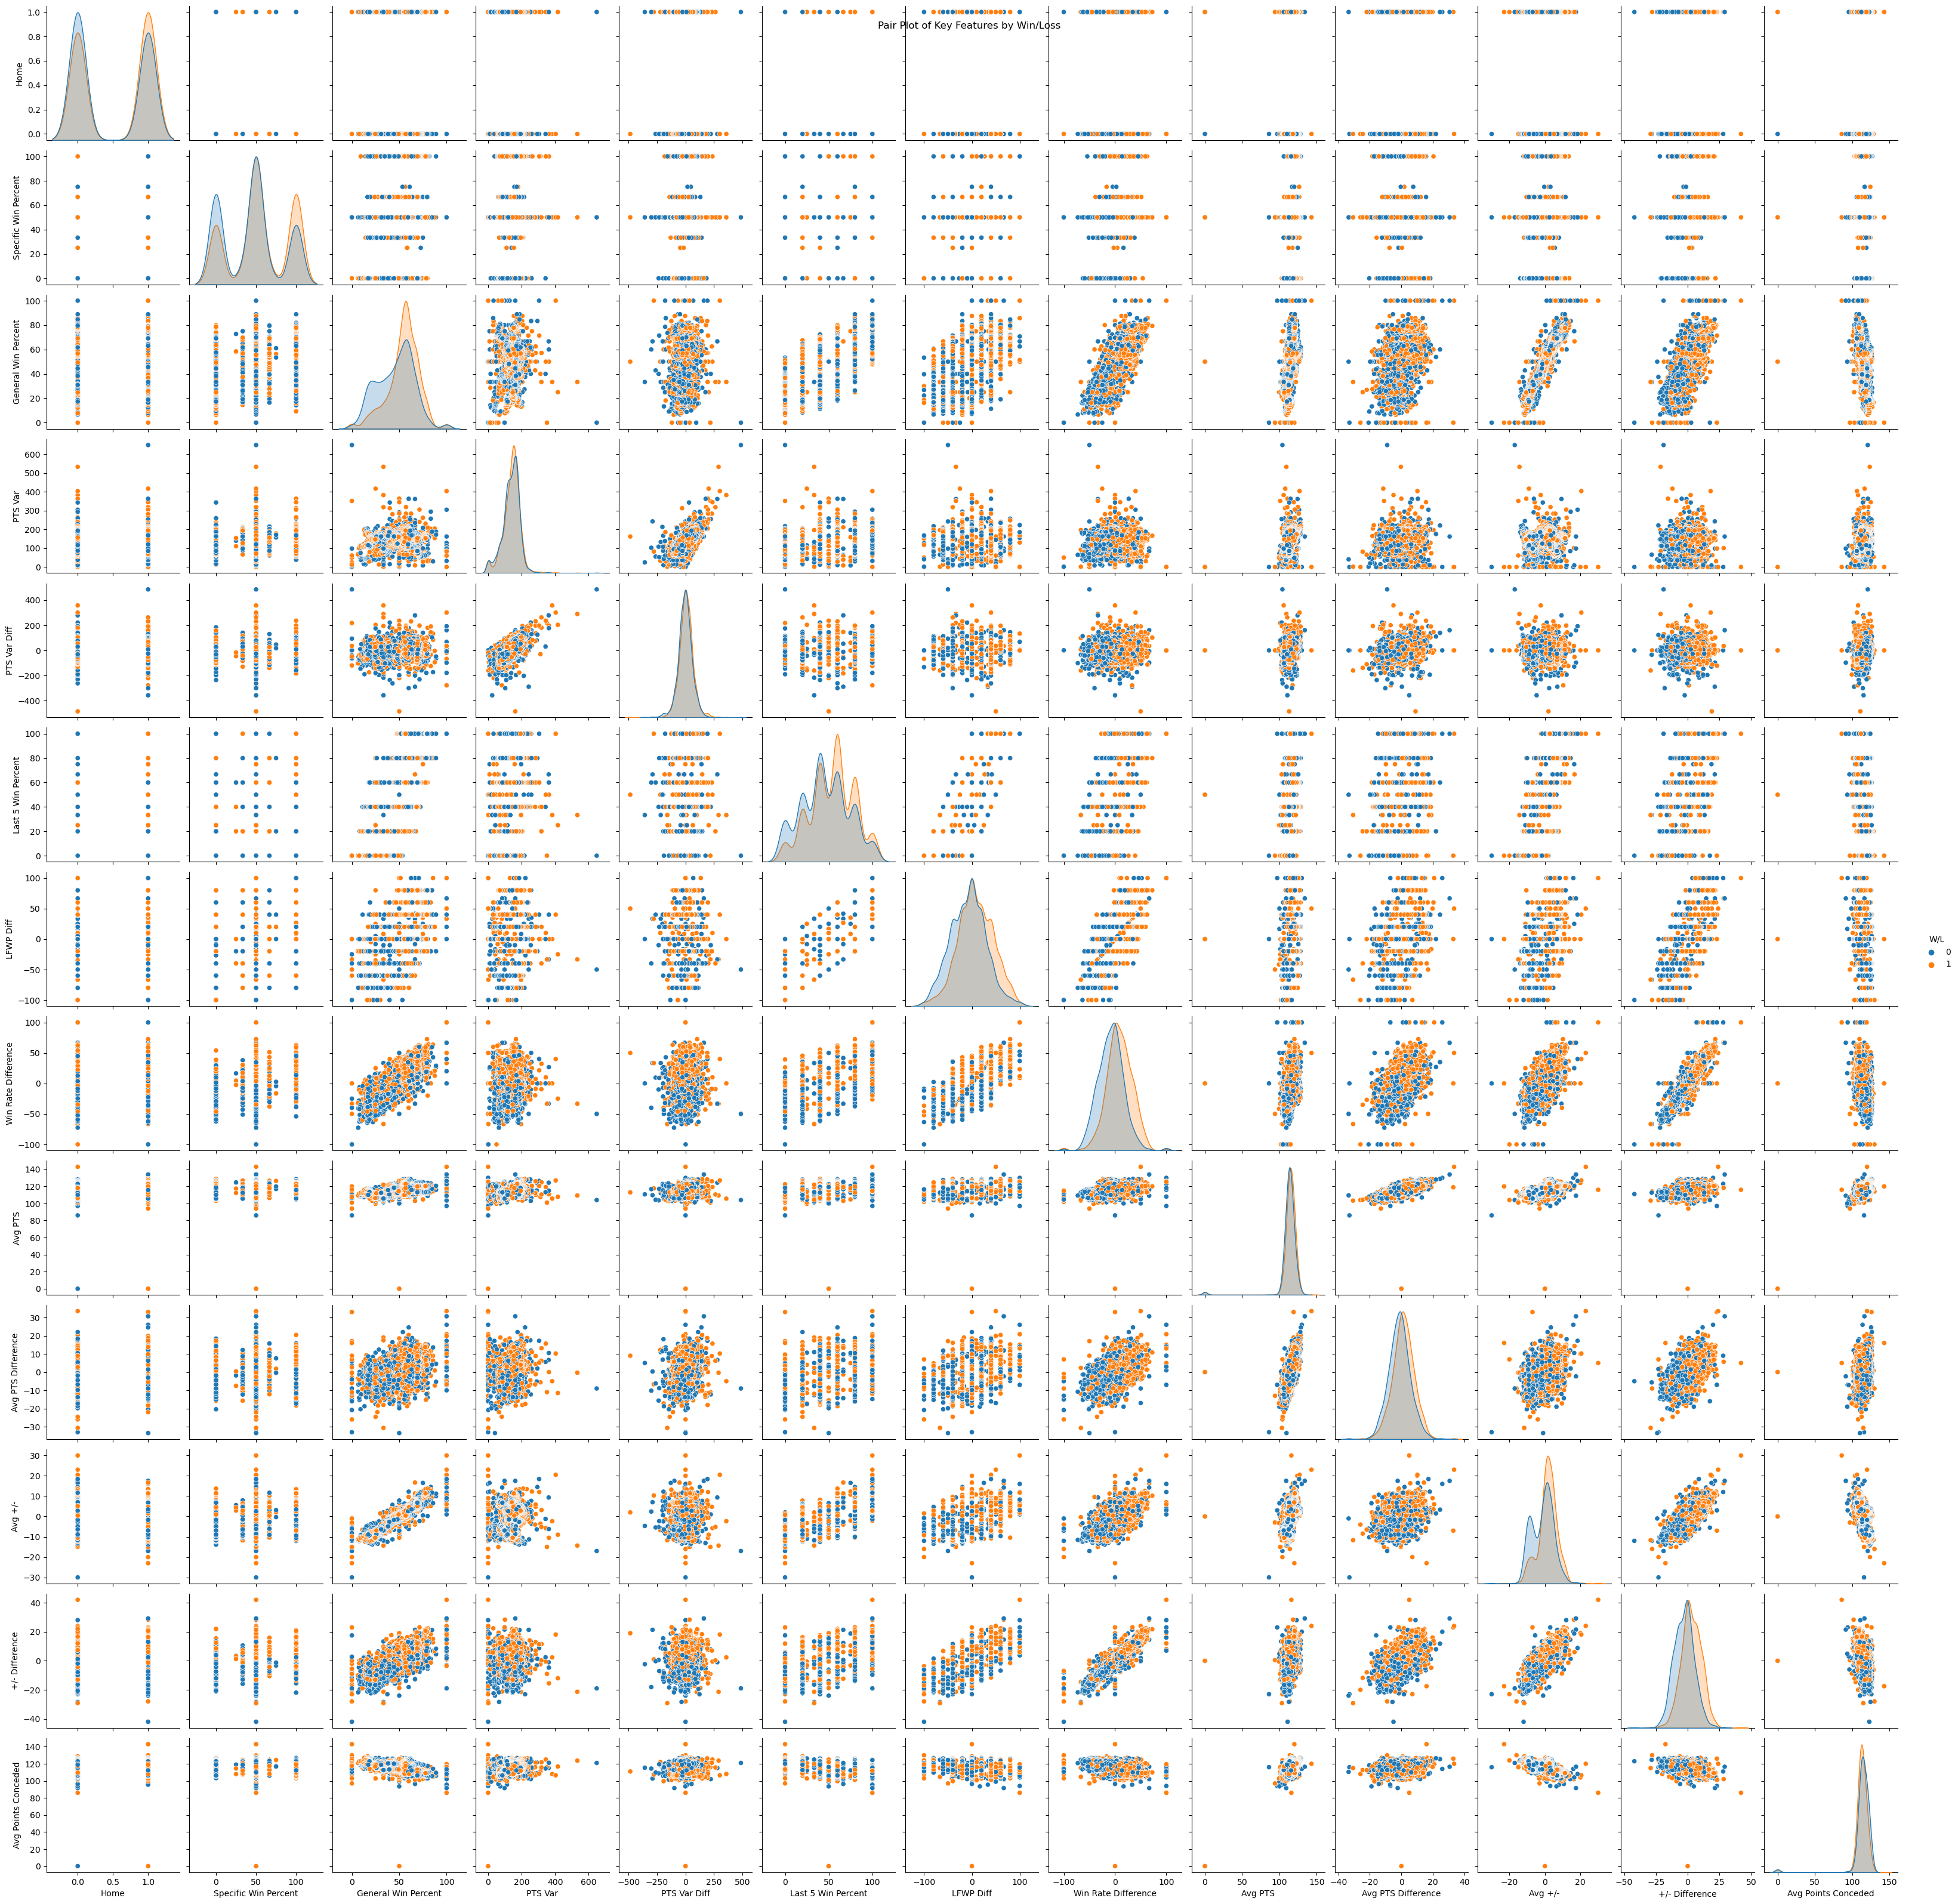

In [34]:
# Correlation matrix
to_drop_cols = ['Team', 'Match Up', 'Game Date','PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 
                'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
subset = df.drop(columns=to_drop_cols)
plt.figure(figsize=(16, 12))
corr_matrix = subset.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Box plots for key features
key_features = ['Home', 'Specific Win Percent', 'General Win Percent', 'PTS Var', 'PTS Var Diff', 'Last 5 Win Percent', 'LFWP Diff', 'Win Rate Difference', 'Avg PTS', 'Avg PTS Difference', 'Avg +/-', '+/- Difference', 'Avg Points Conceded']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(key_features):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x='W/L', y=feature, data=df)
    plt.title(f'Box plot of {feature} by Win/Loss')
    plt.xlabel('Win (1) or Loss (0)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Pair plot for key features
sns.pairplot(df, vars=key_features, hue='W/L')
plt.suptitle('Pair Plot of Key Features by Win/Loss')
plt.show()

# OK lets do some more stuff

In [37]:
df = pd.read_excel("../Dataset.xlsx")
df['Home'] = df['Match Up'].apply(lambda x: 0 if '@' in x else (1 if 'vs.' in x else None))
df['Game Date'] = pd.to_datetime(df['Game Date'], format='%m/%d/%Y')
df['W/L'] = df['W/L'].apply(lambda x: 1 if x == 'W' else 0)

df.fillna(0, inplace=True)
df.replace('-', 0, inplace=True)

def get_opponent_row(df, current_row):
    # Extract game details
    match_up = current_row['Match Up']
    game_date = current_row['Game Date']
    current_team = current_row['Team']

    # Identify the opposing team
    team_A, team_B = match_up[:3], match_up[-3:]
    opponent_team = team_B if current_team == team_A else team_A

    # Find the row corresponding to the opponent
    opponent_row = df[
        (df['Game Date'] == game_date) & (df['Team'] == opponent_team)
    ]

    return opponent_row

def specific_win_rate(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        other_games = df[df['Match Up'].str.contains(team_A) & df['Match Up'].str.contains(team_B) & (df["Team"] == row["Team"])]
        date = row["Game Date"]
        prior_games = other_games[other_games["Game Date"] < date]
        if(len(prior_games) == 0):
            prior_rate = 50
        else: 
            prior_wins = (prior_games["W/L"]).sum()
            prior_rate = (prior_wins/len(prior_games)) * 100
        df.loc[i,"Specific Win Percent"] = prior_rate

specific_win_rate(df)

def general_win_percent(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        if(len(prior_games) == 0):
            prior_rate = 50
        else:
            prior_wins = (prior_games["W/L"]).sum()
            prior_rate = (prior_wins/len(prior_games)) * 100
        df.loc[i,"General Win Percent"] = prior_rate

general_win_percent(df)

def PTS_Var(df):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team = row["Team"]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        if(len(prior_games) == 0):
            PTS_Var = 0
        else:
            PTS_Var = prior_games["PTS"].var()
        df.loc[i,"PTS Var"] = PTS_Var

PTS_Var(df)

'''
def PTS_Var_Diff(df):
    df["PTS Var Diff"] = np.nan  

    for i in range(len(df)): 
            row = df.iloc[i,:]
            my_pts_var = row["PTS Var"]
            opponent = get_opponent_row(df, row)
            opp_pts_var = opponent["PTS Var"]
            diff = my_pts_var - opp_pts_var
            df.loc[i,"PTS Var Diff"] = diff.iloc[0]


PTS_Var_Diff(df)
'''

def last_5_win_percent(df):
    for i in range(len(df)):
        row = df.iloc[i, :]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        
        if len(prior_games) == 0:
            # Default to 50% if no prior games exist
            prior_rate = 50
        elif len(prior_games) < 5:
            # Calculate win percentage for all prior games
            prior_wins = (prior_games["W/L"]).sum()
            prior_rate = (prior_wins / len(prior_games)) * 100
        else:
            # Sort and calculate win percentage for the last 5 prior games
            sorted_df = prior_games.sort_values(by='Game Date')
            last5 = sorted_df.tail(5)
            prior_wins = (last5["W/L"]).sum()
            prior_rate = (prior_wins / len(last5)) * 100
        
        # Assign the calculated value
        df.at[i, "Last 5 Win Percent"] = prior_rate

last_5_win_percent(df)

def LFWPD(df):
     for i in range(len(df)):
        row = df.iloc[i,:]
        my_lfwp = row["Last 5 Win Percent"]
        opponent = get_opponent_row(df, row)
        opp_lfwp = opponent["Last 5 Win Percent"]
        diff = my_lfwp - opp_lfwp
        df.loc[i,"LFWP Diff"] = diff.iloc[0]

LFWPD(df)

def calculate_avg_pts(df):
    for i in range(len(df)):
        row = df.iloc[i, :]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]

        # Get prior games for the current team
        prior_games = team_games[team_games["Game Date"] < date]
        if len(prior_games) == 0:
            avg_pts = 0  # Default if no prior games
        else:
            avg_pts = prior_games["PTS"].mean()  # Calculate average points

        # Add the calculated average to a new column
        df.loc[i, "Avg PTS"] = avg_pts

calculate_avg_pts(df)

def calculate_avg_plus_minus(df):
    df["Avg +/-"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        current_team = row["Team"]
        game_date = row["Game Date"]

        # Filter for prior games of the same team
        prior_games = df[(df["Team"] == current_team) & (df["Game Date"] < game_date)]

        if len(prior_games) == 0:
            avg_plus_minus = 0  # Default if no prior games
        else:
            avg_plus_minus = prior_games["+/-"].mean()

        # Assign the calculated average
        df.loc[i, "Avg +/-"] = avg_plus_minus

calculate_avg_plus_minus(df)

def calculate_avg_points_conceded(df):
    df["Avg Points Conceded"] = 0  # Initialize the new column with 0

    for i in range(len(df)):
        row = df.iloc[i]
        current_team = row["Team"]
        game_date = row["Game Date"]

        # Find prior games where the current team played
        prior_games = df[(df["Team"] != current_team) & (df["Match Up"].str.contains(current_team)) & (df["Game Date"] < game_date)]

        if len(prior_games) == 0:
            avg_points_conceded = 0  # Default if no prior games
        else:
            # Use the PTS column from the opponent in those games
            avg_points_conceded = prior_games["PTS"].mean()

        # Assign the result
        df.loc[i, "Avg Points Conceded"] = avg_points_conceded

calculate_avg_points_conceded(df)

def weighted_win_rate(df, alpha = .6):
    for i in range(len(df)):
        row = df.iloc[i,:]
        team = row["Team"]
        team_games = df[df["Team"] == row["Team"]]
        date = row["Game Date"]
        prior_games = team_games[team_games["Game Date"] < date]
        if len(prior_games) == 0:
            weighted_win_rate = 50
        else:
            weights = []
            for j in range(len(prior_games)):   
                mult = len(prior_games) - j
                weights.append(alpha ** mult)
            weights = np.array(weights)
            weights = weights/sum(weights)
            weighted_win_rate = sum(weights * prior_games["W/L"])
        df.loc[i,"Weighted General Win Percent"] = weighted_win_rate

weighted_win_rate(df, .2)

def has_non_numeric(df):
    non_numeric_cols = []
    for col in df.columns:
        try:
            pd.to_numeric(df[col])
        except (ValueError, TypeError):
            non_numeric_cols.append(col)
    return non_numeric_cols

has_non_numeric(df)

'''
def calculate_win_rate_difference(df):
    df["Win Rate Difference"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Find the opponent's General Win Percent
        opponent_row = df[
            (df["Team"] == opponent_team) &
            (df["Game Date"] == row["Game Date"])
        ]

        if not opponent_row.empty:
            opponent_rate = opponent_row["General Win Percent"].values[0]
        else:
            opponent_rate = 50  # Default if no opponent info

        # Calculate the difference
        current_team_rate = row["General Win Percent"]
        df.loc[i, "Win Rate Difference"] = current_team_rate - opponent_rate

calculate_win_rate_difference(df)
'''

'''
def calculate_pts_diff(df):
    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Get the opponent's Avg PTS
        opponent_row = df[
            (df["Team"] == opponent_team) &
            (df["Game Date"] == row["Game Date"])
        ]

        if not opponent_row.empty:
            opponent_avg_pts = opponent_row["Avg PTS"].values[0]
        else:
            opponent_avg_pts = 0  # Default if no data for opponent

        # Calculate the PTS difference
        pts_diff = row["Avg PTS"] - opponent_avg_pts
        df.loc[i, "Avg PTS Difference"] = pts_diff

# Apply the function
calculate_pts_diff(df)
'''

'''
def calculate_plus_minus_difference(df):
    df["+/- Difference"] = None  # Initialize the new column

    for i in range(len(df)):
        row = df.iloc[i]
        team_A = row["Match Up"][:3]
        team_B = row["Match Up"][-3:]
        current_team = row["Team"]
        opponent_team = team_B if team_A == current_team else team_A

        # Find the Avg +/- of the opponent
        opponent_avg_plus_minus = df.loc[
            (df["Team"] == opponent_team) & (df["Game Date"] == row["Game Date"]),
            "Avg +/-"
        ]
        
        if not opponent_avg_plus_minus.empty:
            opponent_avg_plus_minus = opponent_avg_plus_minus.values[0]
        else:
            opponent_avg_plus_minus = 0  # Default if no opponent info

        # Calculate the difference
        df.loc[i, "+/- Difference"] = row["Avg +/-"] - opponent_avg_plus_minus

calculate_plus_minus_difference(df)
'''

def opp_feature_calc(df, feature):
    for i in range(len(df)):
        row = df.iloc[i,:]
        my_val = row[feature]
        opponent = get_opponent_row(df, row)
        opp_val = opponent[feature].iloc[0]
        opp_name = "Opp " + feature
        df.loc[i,opp_name] = opp_val
        diff_name = "Diff " + feature
        diff = my_val - opp_val
        df.loc[i, diff_name] = diff


analysis_features = ['General Win Percent', 'Avg PTS', 'Avg +/-', 'Avg Points Conceded', 'Weighted General Win Percent']

for feature in analysis_features:
    opp_feature_calc(df, feature)

print(df.columns)

Index(['Team', 'Match Up', 'Game Date', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'Home', 'Specific Win Percent',
       'General Win Percent', 'PTS Var', 'Last 5 Win Percent', 'LFWP Diff',
       'Avg PTS', 'Avg +/-', 'Avg Points Conceded',
       'Weighted General Win Percent', 'Opp General Win Percent',
       'Diff General Win Percent', 'Opp Avg PTS', 'Diff Avg PTS',
       'Opp Avg +/-', 'Diff Avg +/-', 'Opp Avg Points Conceded',
       'Diff Avg Points Conceded', 'Opp Weighted General Win Percent',
       'Diff Weighted General Win Percent'],
      dtype='object')


In [70]:
df = df.sort_values(by="Game Date")

y = df["W/L"]
X = df.loc[:, ["Home", 'Diff Weighted General Win Percent', 'Avg PTS', "Opp Avg PTS", "Avg Points Conceded", "Diff Avg Points Conceded", "Diff General Win Percent", "PTS Var"]]

X = X.iloc[300:]
y = y.iloc[300:]

X_train = X.iloc[:2000]
X_test = X.iloc[2000:]

y_train = y.iloc[:2000]
y_test = y.iloc[2000:]

In [ ]:
from sklearn.linear_model import Lasso

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler


# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 67.50%


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Fit the model using the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Random Forest Accuracy: {accuracy:.2f}%")

Random Forest Accuracy: 61.88%


In [74]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize XGBoost model
xgb_model = GradientBoostingClassifier(n_estimators=1111, max_depth=50, random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb) * 100
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}%")


XGBoost Accuracy: 60.62%


In [75]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

# Train Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Alpha controls the strength of regularization
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)
accuracy_ridge = accuracy_score(y_test, (y_pred_ridge > 0.5).astype(int)) * 100
print(f"Ridge Accuracy: {accuracy_ridge:.2f}%")

Ridge Accuracy: 67.50%


In [76]:
from sklearn.linear_model import Lasso
import pandas as pd

# Initialize and train the Lasso model
lasso_model = Lasso(alpha=0.1, random_state=42)  # Adjust alpha for stronger/looser regularization
lasso_model.fit(X_train, y_train)

# Extract feature importance (coefficients)
feature_importance = pd.Series(lasso_model.coef_, index=X.columns)

# Filter out features with zero coefficients (not useful)
useful_features = feature_importance[feature_importance != 0].sort_values(ascending=False)

# Predict and evaluate
y_pred_ridge = lasso_model.predict(X_test)
accuracy_ridge = accuracy_score(y_test, (y_pred_ridge > 0.5).astype(int)) * 100
print(f"Lasso Accuracy: {accuracy_ridge:.2f}%")

print("Useful features identified by Lasso:")
print(useful_features)

Lasso Accuracy: 68.75%
Useful features identified by Lasso:
Diff General Win Percent    0.007477
PTS Var                    -0.000010
Diff Avg Points Conceded   -0.000282
dtype: float64


In [77]:
from sklearn import svm

model = svm.SVC()
model.fit(X_train, y_train)
# Predict using the SVM model
predictions = model.predict(X_test)
accuracy = model.score(X_test, y_test)
train_accuracy = model.score(X_train, y_train)
print("Accuracy of SVM:", accuracy,train_accuracy)


Accuracy of SVM: 0.6875 0.6415


In [91]:
import pandas as pd
import numpy as np
from sklearn import svm

Path = "../Dataset.xlsx"
df = pd.read_excel(Path)
Home = []
for i in range(df.shape[0]):
    if df.iloc[:, 1][i][4:6]=='vs':
        Home.append(1)
    if df.iloc[:,1][i][4:6]=='@ ':
        Home.append(0)
df['home'] = np.array(Home)
df.loc[df['W/L'] == 'W', 'W/L'] = 1
df.loc[df['W/L'] == 'L', 'W/L'] = 0
df.loc[df['FT%']=='-','FT%']=1


Features = ['W/L','PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
for i in Features:
    df[i] = df[i].astype(float)

X_all = []
Y_all = []
def Weighting_fun(L,alpha=0.5):
    Res = [alpha ** i for i in np.arange(L,0,-1)]
    Res /= np.sum(Res)
    return Res


for i in np.arange(150,df.shape[0]):
    Team_1 = df.iloc[i,0]
    Team_2 = df.iloc[i,1][-3::]
    Data_Previous_1 = (df.iloc[0:i,:][df.iloc[0:i,0]==Team_1])
    Data_Previous_2 = (df.iloc[0:i,:][df.iloc[0:i,0]==Team_2])
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == df.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1-df.iloc[i, -1])][Features])
    W1 = Weighting_fun(Data_Previous_1_home.shape[0],0.4).reshape(-1,1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0],0.4).reshape(-1,1)
    Data_1 = np.array(Data_Previous_1_home[:,3::] * W1).mean(axis=0)
    Data_2 = np.array(Data_Previous_2_home[:,3::] * W2).mean(axis=0)
    Diff = (Data_1 - Data_2).tolist() + [df.iloc[i,-1]]
    X_all.append(Diff)
    Y_all.append(df.iloc[i]['W/L'])

X = np.array(X_all)
y = np.array(Y_all)
# Load a dataset (using iris dataset as example)
def z_score_normalize(arr):
    mean_val = arr.mean(axis=0)
    std_val = arr.std(axis=0)
    return (arr - mean_val) / std_val

X_train, X_test, y_train, y_test = X[0:1500,:], X[1500::,:], y[0:1500],y[1500::]
model = svm.SVC()
model.fit(X_train, y_train)
# Predict using the SVM model
predictions = model.predict(X_test)
accuracy = model.score(X_test, y_test)
train_accuracy = model.score(X_train, y_train)
print("Accuracy of SVM:", accuracy,train_accuracy)



# OK so lets do lasso
from sklearn.linear_model import Lasso
import pandas as pd

# Initialize and train the Lasso model
lasso_model = Lasso(alpha=0.05, random_state=42)  # Adjust alpha for stronger/looser regularization
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = lasso_model.predict(X_test)
accuracy_ridge = accuracy_score(y_test, (y_pred_ridge > 0.5).astype(int)) * 100
print(f"Lasso Accuracy: {accuracy_ridge:.2f}%")

Accuracy of SVM: 0.7148148148148148 0.7146666666666667
Lasso Accuracy: 70.99%
